# PSF exploration in DP0.2 images

version: Weekly 2023_47 <br>
Container Size: medium 

**Description:** In this notebook we explore the properties of the PSF model from DP0.2 images. First we show how to extract the PSF model from DP0.2 single exposures (calexp) and coaded images (deepCoadd) using the method `getPsf()` from the `Exposure` class, as well as querying both the src and object tables, respectively. Then we explore the diferences between the PSF model and the actual measurements of the source, and plot residual distributions. Finally, we explore the variability of PSF size and shape across the whole visit and in coadded regions of ~1deg$^2$ and its dependence on the observing wavelength.

**Contributor:** K.A. Alamo-Martinez

---
# Set up

In [20]:
### Rubin-specific packages
from lsst.daf.butler import Butler
import lsst.geom as geom
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')
from lsst.rsp import get_tap_service
service = get_tap_service("tap")

### General python / astronomy packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import time

# To ignore some kinds of warnings
import warnings
warnings.filterwarnings('ignore')

---

# 1. PSF model extraction from DP0.2 images
## 1.1 Using the method `getPsf()` from the `Exposure` class 


In [2]:
repo = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(repo, collections=collection)

In [3]:
dataId = {'visit': '400357', 'detector': 43}
calexp = butler.get('calexp', dataId=dataId)

### 1.1.1 PSF extraction from a calexp

Since the PSF variates across the image, we have to give the coordinates (central position in pixels) from where we want to retrieve the PSF. In this example the coordinates are (100,100). If there's no point given, it returns te central one.

In [4]:
point = geom.PointD(100.,100.)

psf = calexp.getPsf()
psf_size = psf.computeShape(point).getDeterminantRadius()
print('psf_size [pix] = ', psf_size)

psf_size [pix] =  2.190995708743641


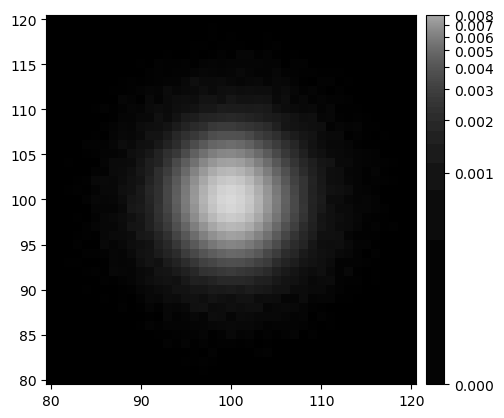

In [5]:
psfimage = psf.computeImage(point)

# one way to display images (the prefered)
display = afwDisplay.Display()
display.scale('asinh', min=0.0, max=1.e-3, unit='absolute')
display.mtv(psfimage)

#### PSF comparison for two different coodinates 

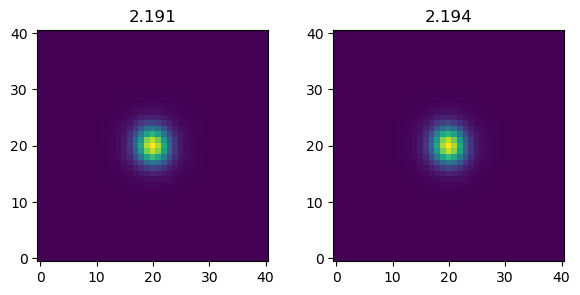

In [6]:
point1 = geom.PointD(10.,10.)
point2 = geom.PointD(20.,400.)

psfimage1 = psf.computeImage(point1)
psfimage2 = psf.computeImage(point2)

psf_size1 = np.round(psf.computeShape(point1).getDeterminantRadius(),3)
psf_size2 = np.round(psf.computeShape(point2).getDeterminantRadius(),3)

# another way to display images
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].set_title(psf_size1)
ax[0].imshow(psfimage1.getArray(), origin='lower')

ax[1].set_title(psf_size2)
ax[1].imshow(psfimage2.getArray(), origin='lower');


### 1.1.2 PSF extraction from a deepCoadd

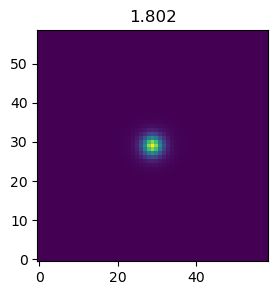

In [7]:
dataId = {'tract': 3831, 'patch': 3, 'band': 'r'}
coadd = butler.get('deepCoadd', **dataId)

psf_coadd = coadd.getPsf()
point = geom.PointD(13000., 500.)
psf_size_coadd = np.round(psf_coadd.computeShape(point).getDeterminantRadius(), 3)
psfimage_coadd = psf_coadd.computeImage(point)

fig, ax = plt.subplots( figsize=(7, 3))
ax.set_title(psf_size_coadd)
ax.imshow(psfimage_coadd.getArray(), origin='lower');


---

## 1.2 Querying PSF information from source/object tables

Working with catalogs could more efficient than manipulating images. In this section we will retrive the moments of the light distribution to then calculate the determinant radius.  

The recomended way to extract catalog data is the TAP service but it is also possible to access through the butler. 

The schemas: https://dm.lsst.org/sdm_schemas/browser/dp02.html

### 1.2.1  src catalog (calexp sources)

To extract the source catalog (src) we have to indicate the id of the calexp from which the catalog was constructed. 
From the src catalog we select the sources used to construct the PSF model and get the moments (Ixx, Iyy, Ixy). 

In [8]:
dataId = {'visit': '400357', 'detector': 43}
src = butler.get('src', **dataId)

# point sources used to model the PSF:
psf_used = src[src['calib_psf_used'] == True] 

# point sources reserved to test the PSF model:
psf_reserved = src[src['calib_psf_reserved'] == True]

i_xx_psf_used = psf_used['base_SdssShape_psf_xx']#shape_psf.getIxx()
i_yy_psf_used = psf_used['base_SdssShape_psf_yy']#shape_psf.getIyy()
i_xy_psf_used = psf_used['base_SdssShape_psf_xy']#shape_psf.getIxy()

### 1.2.2  object catalog (deepCoadd sources)

The catalog of sources contructed form a deepCoadd is called objectTable, and we have to give the id of the deepCoadd. 

In [9]:
dataId = {'tract': 3831, 'patch': 3, 'band': 'r'}
obj = butler.get('objectTable', **dataId)

# point sources:
point_sources = obj[obj['refExtendedness'] == 0]

i_xx_point = point_sources['r_ixxPSF']
i_yy_point = point_sources['r_iyyPSF']
i_xy_point = point_sources['r_ixyPSF']

In [10]:
# function to calculate the size and ellipticity using the intensity moments

def PSF_shape(i_xx, i_yy, i_xy):
    ''' function to calculate the size and elipticity
    using the light moments. Output in pixels'''
    theta = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
    e1 = (i_xx - i_yy) / (i_xx + i_yy)
    e2 = (2. * i_xy) / (i_xx + i_yy)
    e = np.sqrt(e1**2 + e2**2)
    TraceRad = np.sqrt((i_xx + i_yy) / 2.)
    DetRad = (i_xx * i_yy - i_xy**2)**(1. / 4.)
    return TraceRad, DetRad, e, e1, e2


---

# 2. Diferences between PSF model and the actual measurements of the source.

### 2.1.1 calexp

In [11]:
def PSF_diagnostics(visit, detector, band): 
    dataId={'band':band,'visit':visit,'detector':detector}  
    calexp = butler.get('calexp', **dataId)
    src = butler.get('src', **dataId)

    psf = calexp.getPsf()
    x_array = np.arange(0, calexp.getDimensions()[0]+1, 200)
    y_array = np.arange(0, calexp.getDimensions()[1]+1, 200)
    xx, yy = np.meshgrid(x_array, y_array)

    size = [] # trace radius
    det_radius = []
    i_xx, i_yy, i_xy = [] , [] , []
    for x, y in zip(xx.flatten(), yy.flatten()):
        point = geom.Point2D(x, y)
        shape = psf.computeShape(point)
        size.append(shape.getTraceRadius())
        det_radius.append(shape.getDeterminantRadius()) 
        i_xx.append(shape.getIxx())
        i_yy.append(shape.getIyy())
        i_xy.append(shape.getIxy())
    size = np.reshape(size, xx.shape)
    i_xx = np.reshape(i_xx, xx.shape)
    i_yy = np.reshape(i_yy, xx.shape)
    i_xy = np.reshape(i_xy, xx.shape)
    det_radius = np.reshape(det_radius, xx.shape)
    dif_rad = np.abs(size - det_radius)

    e1 = (i_xx - i_yy) / (i_xx + i_yy)
    e2 = (2. * i_xy) / (i_xx + i_yy)
    e = np.sqrt(e1**2 + e2**2)
    theta = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
    ex = e * np.cos(theta)
    ey = e * np.sin(theta)
        
    def comparison_src_psf(sample):
        output = []
        for i in range(len(sample)):
            point = sample[i].getCentroid()
            shape_psf = psf.computeShape(point)
            i_xx_psf = sample[i]['base_SdssShape_psf_xx']
            i_yy_psf = sample[i]['base_SdssShape_psf_yy']
            i_xy_psf = sample[i]['base_SdssShape_psf_xy']
            TraceRad_psf, DetRad_psf, e_psf, e1_psf, e2_psf = PSF_shape(i_xx_psf, i_yy_psf, i_xy_psf)

            i_xx_src = sample[i]['base_SdssShape_xx']
            i_yy_src = sample[i]['base_SdssShape_yy']
            i_xy_src = sample[i]['base_SdssShape_xy']
            e_src = PSF_shape(i_xx_src, i_yy_src, i_xy_src)[2]
            TraceRad_src , DetRad_src , e_psf, e1_psf, e2_psf= PSF_shape(i_xx_src, i_yy_src, i_xy_src)
            x_point = point[0]
            y_point = point[1]
            mag = -2.5*np.log10(sample[i]['base_CircularApertureFlux_17_0_instFlux'])
            output.append([x_point, y_point, TraceRad_psf, DetRad_psf, e_psf, TraceRad_src, DetRad_src, e_src, mag])

        return np.asarray(output)

    #psf_used = src[(src['calib_psf_used'] == True) & (-2.5*np.log10(src['base_CircularApertureFlux_17_0_instFlux']) > -13)]
    #psf_reserved = src[(src['calib_psf_reserved'] == True) & (-2.5*np.log10(src['base_CircularApertureFlux_17_0_instFlux']) > -13)]

    psf_used = src[src['calib_psf_used'] == True]
    psf_reserved = src[src['calib_psf_reserved'] == True]
    
    used = comparison_src_psf(psf_used)
    reserved = comparison_src_psf(psf_reserved)

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    #############  CALEXP  #############
    plt.sca(ax[0,0])  
    display1 = afwDisplay.Display(frame=fig)
    display1.scale('linear', 'zscale')
    display1.mtv(calexp.image)
    display1.show_colorbar(False)
    plt.text(150, 150, band +" band", color = 'y', fontsize=20)
    plt.text(150, 3700, "visit "+ str(visit) + "   detector " + str(detector), color = 'orange', fontsize=18)
    for s in psf_used:
        plt.plot(s.getX(), s.getY(), 'o', ms=6, mew=1.5, mfc = 'None', mec = 'b')

    #############  TRACE RADIUS  #############
    plt.sca(ax[0,1])
    plt.pcolormesh(xx, yy, size, vmin=np.min(size), vmax=np.max(size), cmap='cool', shading='auto')
    colorbar = plt.colorbar(label='Trace Radius [pix]')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Size')

    x_used = used[:,0]
    y_used = used[:,1]
    TraceRad_used = used[:,5]
    plt.rcParams['scatter.edgecolors'] = "k"
    marker_size_mag = np.abs(used[:,8]**4)*0.001
    plt.scatter(x_used, y_used, c=TraceRad_used, s = marker_size_mag, vmin=np.min(size), vmax=np.max(size), cmap='cool')

    #############  ELLIPTICITY STICKS  #############
    plt.sca(ax[1,0])
    plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.01, cmap='plasma')
    colorbar = plt.colorbar(label='e')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Ellipticity Sticks')

    ############# ELLIPTICITY  #############
    plt.sca(ax[1,1])
    plt.pcolormesh(xx, yy, e, vmin=np.min(e), vmax=np.max(e), cmap='plasma', shading='auto')
    colorbar = plt.colorbar(label='e')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Ellipticity');
    e_used = used[:,7]
    plt.rcParams['scatter.edgecolors'] = "k"
    plt.scatter(x_used, y_used, c=e_used, s = marker_size_mag, vmin=np.min(e), vmax=np.max(e), cmap='plasma')


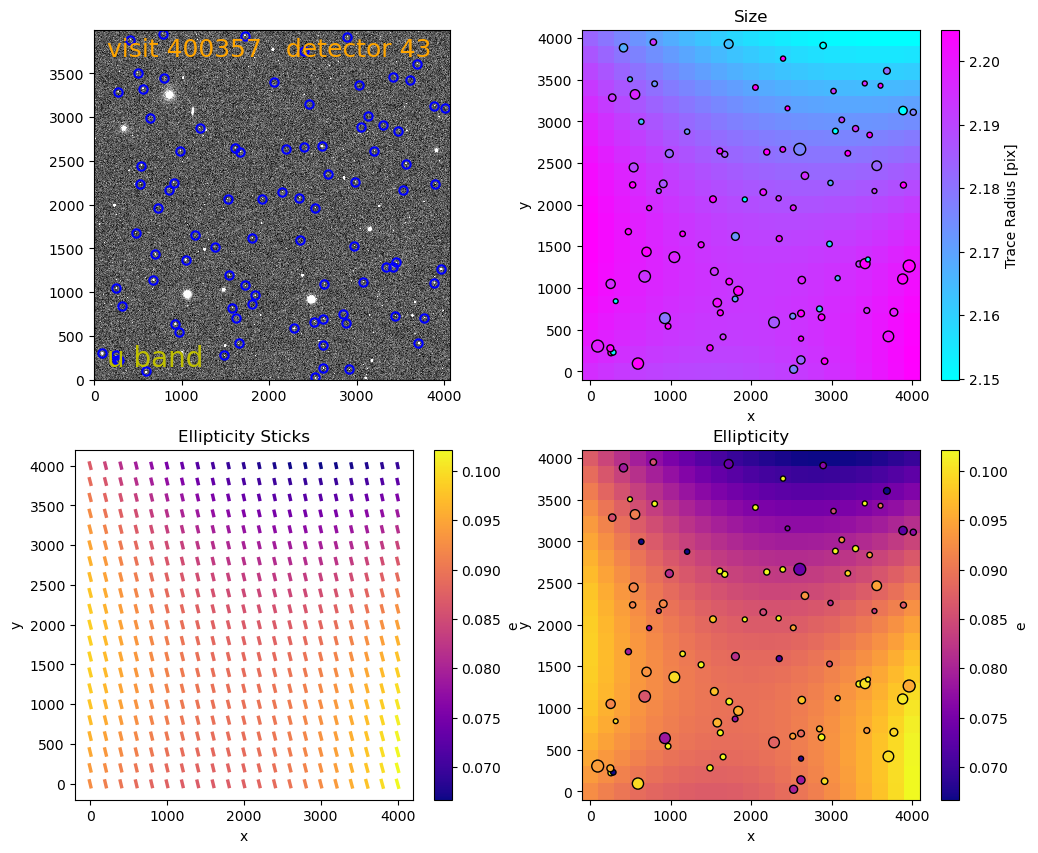

In [12]:
PSF_diagnostics(400357, 43, 'u')

In [13]:
def plot_PSFresiduals(visit, detector, band):
    dataId = {'visit': visit, 'detector': detector, 'band': band}
    calexp = butler.get('calexp', dataId = dataId)
    src = butler.get('src', dataId)
    psf_used = src[src['calib_psf_used'] == True]
    psf_reserved = src[src['calib_psf_reserved'] == True]
    residuals = calexp.maskedImage.getImage()
    psf = calexp.getPsf()
    
    def plot_residuals(stars_type, ncol):
    
        if stars_type == 'reserved': 
            stars_t = psf_reserved
            title = r'Stars reserved to test PSF '
            color_title = 'lime'
        else: 
            stars_t = psf_used
            title = r'Stars used for PSF '
            color_title = 'k'

        nrow = int(len(stars_t)/ncol)
        f, ax = plt.subplots(ncols=ncol, nrows=nrow, sharex=False, sharey=False, figsize=(10, 10*(nrow/6)))

        i=0
        for r in range(nrow):
            for c in range(ncol):
                psfImage = psf.computeImage(stars_t[i].getCentroid()).convertF()
                psfImage *= stars_t[i].getPsfInstFlux()/np.sum(psfImage.getArray())
                flux = psfImage.getArray() - residuals[psfImage.getBBox()].getArray()
                ax[r,c].imshow(flux, origin='lower', cmap = 'Greys', vmin=-150, vmax=130)
                ax[r,c].set_axis_off()
                i = i + 1
        plt.title(title, color=color_title, fontsize=20, x=-1.5, y=nrow*1.04)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.01,hspace=0.01);

    plot_residuals('reserved', 6)
    plot_residuals('used', 6)


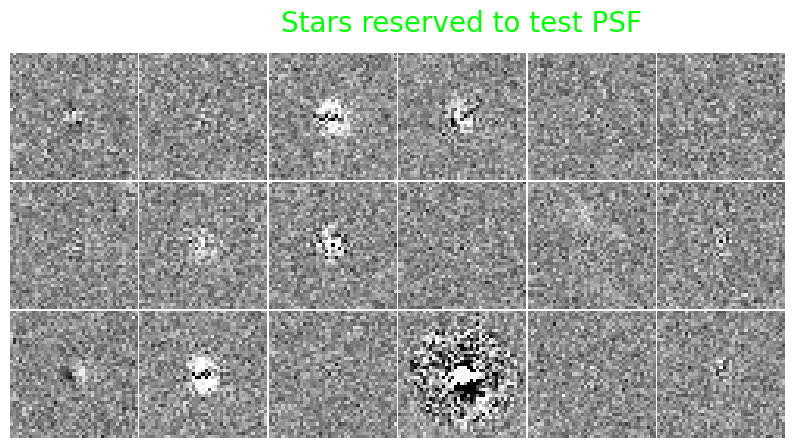

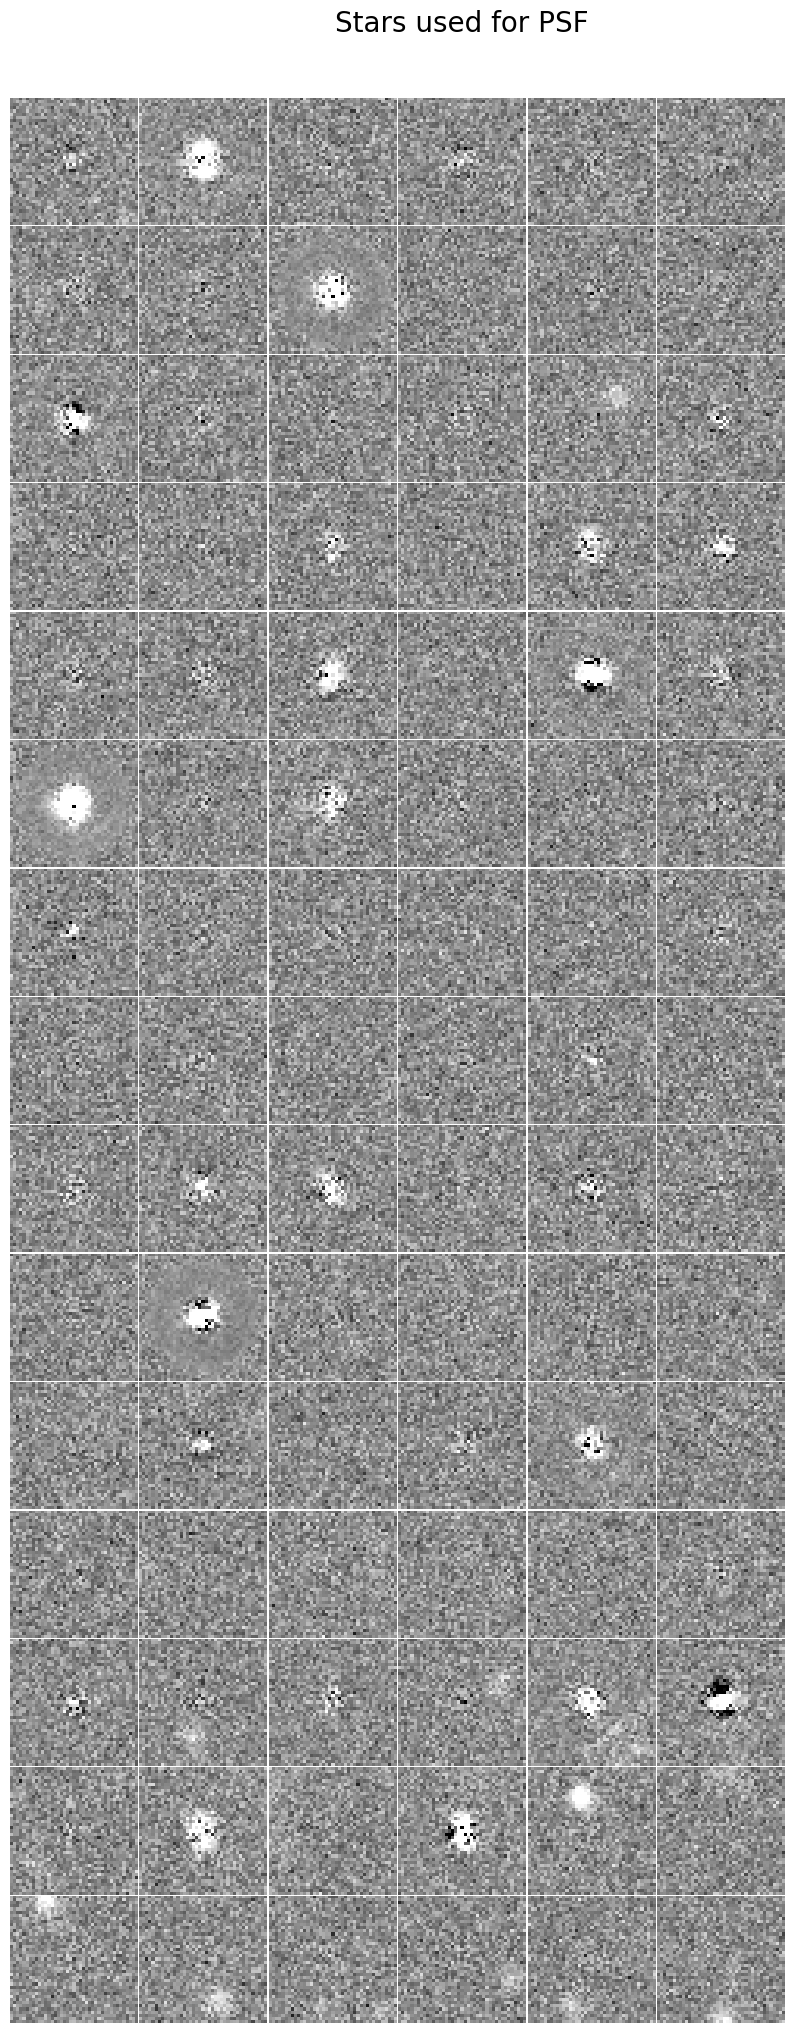

In [14]:
plot_PSFresiduals(400357, 43, 'u')

## 2.2 Residuals

In [15]:
def PSF_star_residuals_Visit(visit,n_ccds,nbins):
    
    output = []
    for det in range(n_ccds):
        xdataId = {'band':'u','visit':visit,'detector': det} 
        ccd = butler.get('calexp', **xdataId)
        src = butler.get('src', **xdataId)
        psf_used = src[src['calib_psf_used'] == True]
        
        for i in range(len(psf_used)):
            i_xx_sdss_psf = psf_used[i]['base_SdssShape_psf_xx']
            i_yy_sdss_psf = psf_used[i]['base_SdssShape_psf_yy']
            i_xy_sdss_psf = psf_used[i]['base_SdssShape_psf_xy']
            TraceRad_psf , DetRad_psf , e_psf, e1_psf, e2_psf = PSF_shape(i_xx_sdss_psf, i_yy_sdss_psf, i_xy_sdss_psf)
            i_xx_sdss_src = psf_used[i]['base_SdssShape_xx']
            i_yy_sdss_src = psf_used[i]['base_SdssShape_yy']
            i_xy_sdss_src = psf_used[i]['base_SdssShape_xy']
            
            TraceRad_star, DetRad_star, e_star, e1_star, e2_star = PSF_shape(i_xx_sdss_src, i_yy_sdss_src, i_xy_sdss_src)
            output.append([TraceRad_psf, e_psf, e1_psf, e2_psf, TraceRad_star, e_star, e1_star, e2_star])
        
    output = np.asarray(output)
    delta_size = output[:,0] - output[:,4] #TraceRad_psf - TraceRad_star
    delta_e1 = output[:,2] - output[:,6] # e1_psf - e1_star
    delta_e2 = output[:,3] - output[:,7] #e2_psf - e2_star

    fig, ax = plt.subplots(1, 3, figsize=(11, 3))

    plt.sca(ax[0])  
    h_size = plt.hist(delta_size, nbins, color = 'b', alpha=0.4 )
    plt.xlabel(r'$\Delta_{size}$', fontsize=16)
    plt.ylabel('N')
    mean_delta_size = np.round(np.mean(delta_size),3)
    plt.axvline(x=mean_delta_size, color='k', ls='--', lw=2, alpha=0.4)
    plt.text(0.02, max(h_size[0])*0.9, str(mean_delta_size), color = 'k', fontsize=12)
    plt.xticks(ticks=[-0.04,-0.02, 0.0, 0.02, 0.04], labels=[-0.04,-0.02, 0.0, 0.02, 0.04])
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.sca(ax[1])  
    h_e1 = plt.hist(delta_e1, nbins, color = 'b', alpha=0.4)
    plt.xlabel(r'$\Delta_{e1}$', fontsize=16)
    #plt.ylabel('N')
    mean_delta_e1 = np.round(np.mean(delta_e1),3)
    plt.axvline(x=mean_delta_e1, color='k', ls='--', lw=2, alpha=0.4)
    plt.text(0.02, max(h_e1[0])*0.9, str(mean_delta_e1), color = 'k', fontsize=12)
    plt.xticks(ticks=[-0.04,-0.02, 0.0, 0.02, 0.04], labels=[-0.04,-0.02, 0.0, 0.02, 0.04])
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.sca(ax[2])  
    h_e2 = plt.hist(delta_e2, nbins, color = 'b', alpha=0.4)
    #print(max(h_e2[0]))
    plt.xlabel(r'$\Delta_{e2}$', fontsize=16)
    #plt.ylabel('N')
    mean_delta_e2 = np.round(np.mean(delta_e2),3)
    plt.axvline(x=mean_delta_e2, color='k', ls='--', lw=2, alpha=0.4)
    plt.text(0.02, max(h_e2[0])*0.9, str(mean_delta_e2), color = 'k', fontsize=12)

    plt.xticks(ticks=[-0.04,-0.02, 0.0, 0.02, 0.04], labels=[-0.04,-0.02, 0.0, 0.02, 0.04])
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)

    plt.subplots_adjust(wspace=0.25)


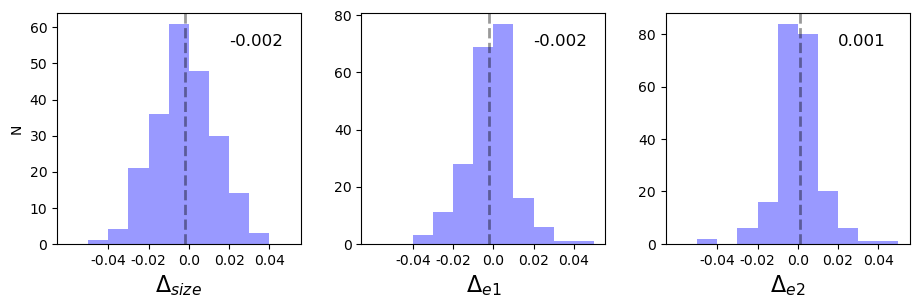

In [16]:
PSF_star_residuals_Visit(159494, 3, np.arange(-0.06, 0.06, 0.01))

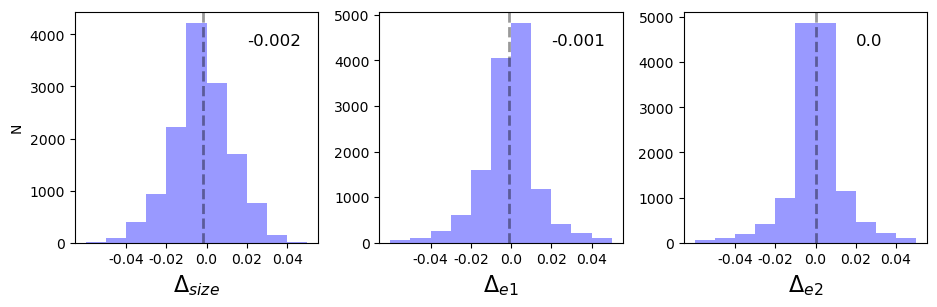

In [17]:
PSF_star_residuals_Visit(159494,189, np.arange(-0.06, 0.06, 0.01))

In [18]:
def PSF_star_residualsScatter_Visit(visit,n_ccds):
    
    output = []
    for det in range(n_ccds):
        xdataId = {'band':'u','visit':visit,'detector': det} 
        ccd = butler.get('calexp', **xdataId)
        src = butler.get('src', **xdataId)
        psf_used = src[src['calib_psf_used'] == True]
        
        for i in range(len(psf_used)):
            i_xx_sdss_psf = psf_used[i]['base_SdssShape_psf_xx']
            i_yy_sdss_psf = psf_used[i]['base_SdssShape_psf_yy']
            i_xy_sdss_psf = psf_used[i]['base_SdssShape_psf_xy']
            TraceRad_psf, DetRad_psf, e_psf, e1_psf, e2_psf = PSF_shape(i_xx_sdss_psf, i_yy_sdss_psf, i_xy_sdss_psf)
            i_xx_sdss_src = psf_used[i]['base_SdssShape_xx']
            i_yy_sdss_src = psf_used[i]['base_SdssShape_yy']
            i_xy_sdss_src = psf_used[i]['base_SdssShape_xy']
            TraceRad_star, DetRad_star, e_star, e1_star, e2_star = PSF_shape(i_xx_sdss_src, i_yy_sdss_src, i_xy_sdss_src)
            mag = -2.5*np.log10(psf_used[i]['base_CircularApertureFlux_17_0_instFlux'])
            output.append([TraceRad_psf, e_psf, e1_psf, e2_psf, TraceRad_star, e_star, e1_star, e2_star, mag])

    output = np.asarray(output)

    df = pd.DataFrame({'TraceRad_psf': output[:,0], 'e_psf': output[:,1], 'e1_psf': output[:,2], 'e2_psf': output[:,3], 'TraceRad_star': output[:,4], 'e_star': output[:,5], 'e1_star': output[:,6], 'e2_star': output[:,7], 'mag': output[:,8]})
    df['delta_size'] = df.TraceRad_psf - df.TraceRad_star 
    df['delta_e1'] = df.e1_psf - df.e1_star 
    df['delta_e2'] = df.e1_psf - df.e1_star 


    bins = np.linspace(df.mag.min(),df.mag.max(), 30)
    
    data_cut = pd.cut(df.mag,bins)           
    grp = df.groupby(by = data_cut)        
    ret = grp.aggregate(np.mean) 
    grp_mead = grp.aggregate(np.median)

    fig, ax = plt.subplots(3, 1, figsize=(8, 8))

    plt.sca(ax[0]) 
    plt.axhline(y=0, color='k', ls='--', lw=1.5, alpha=0.7)
    plt.scatter(df.mag, df.delta_size, marker='.', color = 'b', alpha=0.2)
    plt.plot(ret.mag, ret.delta_size,'r',lw=1,alpha=.7)
    plt.plot(grp_mead.mag, grp_mead.delta_size,'lime',lw=1,alpha=.7)
    #plt.scatter(mag, delta_size, marker='.', color = 'b', alpha=0.2)
    plt.ylabel(r'$\Delta_{size}$',  fontsize=20)
    plt.ylim(-0.06, 0.06)
    plt.yticks(fontsize = 14)
    plt.yticks(ticks=[-0.05, -0.025, 0.0, 0.025, 0.05], labels=[-0.05, -0.025, 0.0, 0.025, 0.05])
    
    plt.sca(ax[1])
    plt.axhline(y=0, color='k', ls='--', lw=1.5, alpha=0.7)
    plt.scatter(df.mag, df.delta_e1, marker='.', color = 'b', alpha=0.2)
    plt.plot(ret.mag, ret.delta_e1,'r',lw=1,alpha=.7)
    plt.ylabel(r'$\Delta_{e1}$',  fontsize=20)
    plt.ylim(-0.1, 0.1)
    plt.xticks(fontsize = 14)
    plt.yticks(ticks=[-0.05, 0.0, 0.05], labels=[-0.05, 0.0, 0.05])
    plt.yticks(fontsize = 14) 
    
    plt.sca(ax[2])  
    plt.axhline(y=0, color='k', ls='--', lw=1.5, alpha=0.7)
    plt.scatter(df.mag, df.delta_e2, marker='.', color = 'b', alpha=0.2)
    plt.plot(ret.mag, ret.delta_e2,'r',lw=1,alpha=.7)
    plt.ylabel(r'$\Delta_{e2}$',  fontsize=20)
    plt.xlabel('magnitude', fontsize=18)
    plt.ylim(-0.08, 0.08)
    plt.xticks(fontsize = 14)
    plt.yticks(ticks=np.arange(-0.08, 0.08, 0.04), labels=[-0.08, -0.04, 0.0, 0.04])
    plt.yticks(fontsize = 14) 
    plt.subplots_adjust(hspace=0.0)

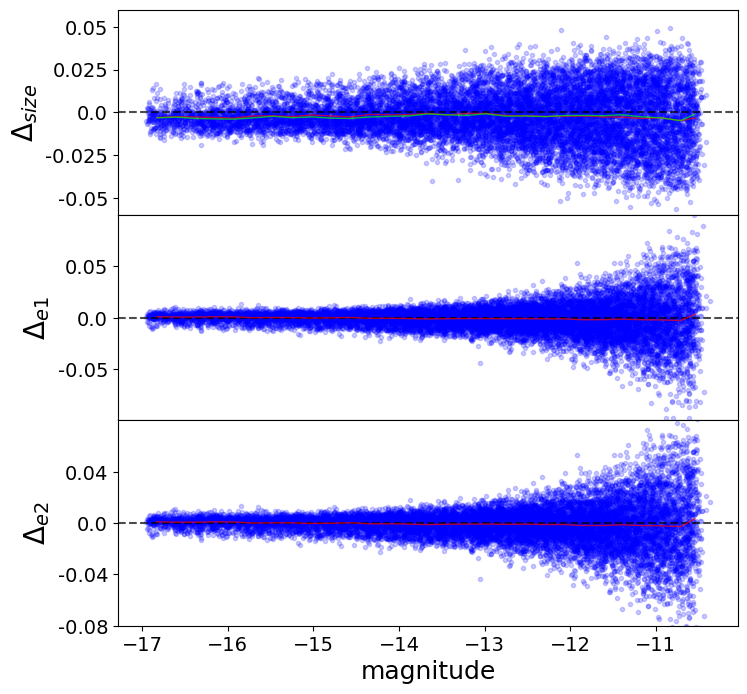

In [22]:
PSF_star_residualsScatter_Visit(159494,189)

---

# 3. PSF size and shape variability
## 3.1 variability across the visit

## 3.2 variability across a coadded region of ~1deg2


## 3.3 variability across different bands